# Búsqueda 


Notebook for the study of a Head Neural Network (HNN) for a representational model using unstructured data.

In [2]:
# Load data
import torch
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import logging as transformers_logging
import warnings
import os
from datetime import datetime

transformers_logging.set_verbosity_error()
warnings.filterwarnings("ignore", message="Some weights of BertModel were not initialized from the model checkpoint.*", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module=r"transformers.tokenization_utils_base")

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths and globals for saving best model during the study
SAVE_DIR = 'study_logs'
os.makedirs(SAVE_DIR, exist_ok=True)
BEST_SCORE = -1.0
BEST_MODEL_PATH = None

data_files = { 'train': 'clean-data/train_clean.csv', 
               'val': 'clean-data/val_clean.csv',
               'test': 'clean-data/test_clean.csv' }

dataset_ES = load_dataset('csv', data_files=data_files)

model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)


## Modelo 

In [3]:
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn

class FullModel(nn.Module):
    def __init__(self, model_ckpt: str, num_labels: int, freeze: bool = False ):
        super(FullModel, self).__init__()
        
        config = AutoConfig.from_pretrained(  model_ckpt
                                            , output_hidden_states=True
                                            , output_attentions=True)
        
        self.encoder = AutoModel.from_pretrained(model_ckpt, config=config)
        self.freeze = freeze
        if freeze: 
            for param in self.encoder.parameters():
                param.requires_grad = False
            
        self.num_labels = num_labels
        hidden_size = config.hidden_size

        self.transformer_block = nn.TransformerEncoderLayer(d_model=hidden_size
                                                            , nhead=8
                                                            , dim_feedforward=hidden_size * 4
                                                            , dropout=0.1
                                                            , activation='gelu')

        # Conv1d + pooling para simular [CLS]
        self.conv1d = nn.Conv1d( in_channels=hidden_size
                                , out_channels=hidden_size 
                                , kernel_size=3
                                , padding=1)
        
        self.pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Sequential(
                                        nn.Linear(hidden_size, hidden_size // 2),
                                        nn.ReLU(),
                                        nn.Dropout(0.1),
                                        nn.Linear(hidden_size // 2, num_labels)
                                        )

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        if self.freeze:
            with torch.no_grad():
                enc_outputs = self.encoder( input_ids=input_ids, attention_mask=attention_mask)
        else:
            enc_outputs = self.encoder( input_ids=input_ids, attention_mask=attention_mask)
            
        last_hidden = enc_outputs.last_hidden_state  # (batch, seq_len, hidden)
        x_block = last_hidden.permute(1, 0, 2)       # (seq_len, batch, hidden)
        x_block = self.transformer_block(x_block)
        x_block = x_block.permute(1, 0, 2)           # (batch, seq_len, hidden)

        # [CLS] vía skip-connection
        block_cls = x_block[:, 0, :]                 # (batch, hidden)
        # [CLS] vía Conv+Pool
        
        x_conv = x_block.permute(0, 2, 1)            # (batch, hidden, seq_len)
        x_conv = self.conv1d(x_conv)
        conv_cls = self.pool(x_conv).squeeze(-1)     # (batch, hidden)
        x = block_cls + conv_cls                     # (batch, hidden)
        x = self.dropout(x)
        logits = self.classifier(x)                  # (batch, num_labels)

        loss = None

        ## NOTA: El proposito es obtener un diccionario en SequenceClassifierOutput, NO LO UTILIZAMO, 
        ## En el train loop hacemos una variante en el criterio de pérdida. 
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct( logits.view(-1, self.num_labels)
                            , labels.view(-1))

        return SequenceClassifierOutput( loss=loss
                                        , logits=logits
                                        , hidden_states=enc_outputs.hidden_states
                                        , attentions=enc_outputs.attentions)


## Funciones para la busqueda

In [ ]:
def transform_dataset(dataset_dict, batch_size=8, max_length=128): 
    """Transform the data into pytorch form and return the dataloaders

    Parameters:
    - dataset_dict: huggingface dataset dict
    - batch_size: int, small to reduce GPU memory pressure
    - max_length: int, tokenization max length
    """
    def tokenize(batch):
      return tokenizer(batch["text"], truncation=True, max_length=max_length)
        
    tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
    # Remove only the text column after tokenization to avoid duplicate columns warnings
    tokenized_dataset = dataset_dict.map(tokenize, batched=True, remove_columns=['text'])
    # Ensure label column is named 'labels' for model compatibility
    if 'label' in tokenized_dataset['train'].column_names:
        tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
    tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "labels"] )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(tokenized_dataset['train'], shuffle = True, batch_size = batch_size, collate_fn = data_collator, num_workers=0, pin_memory=True)
    eval_dataloader = DataLoader(tokenized_dataset['val'], shuffle = False, batch_size = batch_size, collate_fn = data_collator, num_workers=0, pin_memory=True)
    return tokenized_dataset, train_dataloader, eval_dataloader

In [6]:
import optuna
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np 
from transformers import get_scheduler
from tqdm.auto import tqdm
from torch import amp
import torch

N_EPOCHS = 3

def eval_model(model, dataloader, device):
    model.eval()
    losses = []
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            torch.cuda.empty_cache()
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            labels = batch["labels"]

            eps = 1e-6
            count0 = (labels == 0).sum().float().clamp_min(eps)
            count1 = (labels == 1).sum().float().clamp_min(eps)
            max_c = torch.max(count0, count1)
            w0 = (max_c / count0).item()
            w1 = (max_c / count1).item()
            w = torch.tensor([w0, w1], dtype=torch.float32, device=device)

            criterion = nn.CrossEntropyLoss(weight=w)
            outputs = model(**batch)
            logits = outputs.logits
            loss = criterion(logits, labels)
            losses.append(loss.item())

            preds = torch.argmax(logits, dim=-1)
            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(labels.cpu().tolist())

    acc = np.mean(np.array(preds_all) == np.array(labels_all))
    f1  = f1_score(labels_all, preds_all, average="binary", pos_label=1)
    return np.mean(losses), acc, f1, preds_all, labels_all


def model_init(trial, freeze_default=True):
    kernel_size = trial.suggest_categorical('kernel_size', [1, 3, 5])
    nhead       = trial.suggest_categorical('nhead',       [2, 4, 8])

    model = FullModel(model_ckpt='dccuchile/bert-base-spanish-wwm-uncased', num_labels=2, freeze=freeze_default)
    hidden_size = model.encoder.config.hidden_size

    model.transformer_block = nn.TransformerEncoderLayer(
        d_model=hidden_size,
        nhead=nhead,
        dim_feedforward=hidden_size * 4,
        dropout=0.1,
        activation='gelu'
    )
    model.conv1d = nn.Conv1d(
        in_channels=hidden_size,
        out_channels=hidden_size,
        kernel_size=kernel_size,
        padding=kernel_size // 2,
    )
    return model


def transform_dataset(dataset_dict, batch_size=8, max_length=128):
    def tokenize(batch):
        return tokenizer(batch["text"], truncation=True, max_length=max_length)

    tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
    tokenized_dataset = dataset_dict.map(tokenize, batched=True, remove_columns=['text'])
    if 'label' in tokenized_dataset['train'].column_names:
        tokenized_dataset = tokenized_dataset.rename_column('label', 'labels')
    tokenized_dataset.set_format('torch', columns=["input_ids", "attention_mask", "labels"] )
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(tokenized_dataset['train'], shuffle = True, batch_size = batch_size, collate_fn = data_collator, num_workers=0, pin_memory=True)
    eval_dataloader = DataLoader(tokenized_dataset['val'], shuffle = False, batch_size = batch_size, collate_fn = data_collator, num_workers=0, pin_memory=True)
    return tokenized_dataset, train_dataloader, eval_dataloader


def objective(trial):
    global BEST_SCORE, BEST_MODEL_PATH

    model = model_init(trial, freeze_default=True).to(device)
    lr  = 5e-5
    num_epochs = N_EPOCHS
    optimizer = AdamW(model.parameters(), lr=lr)
    dataset_dict = dataset_ES
    _, train_dataloader, eval_dataloader = transform_dataset(dataset_dict, batch_size=8, max_length=128)
    total_steps = max(1, num_epochs * len(train_dataloader))
    lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    scaler = amp.GradScaler()
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            torch.cuda.empty_cache()
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            labels = batch["labels"]

            eps = 1e-6
            cnt0 = (labels==0).sum().float().clamp_min(eps)
            cnt1 = (labels==1).sum().float().clamp_min(eps)
            max_cnt = torch.max(cnt0, cnt1)
            w0 = (max_cnt/cnt0).item()
            w1 = (max_cnt/cnt1).item()
            weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)
            criterion = nn.CrossEntropyLoss(weight=weights)

            optimizer.zero_grad()
            try:
                with amp.autocast(device_type='cuda'):
                    outputs = model(**batch)
                    loss    = criterion(outputs.logits, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                lr_scheduler.step()
            except RuntimeError as e:
                if 'out of memory' in str(e).lower():
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise

        va_loss, va_acc, va_f1, _, _ = eval_model(model, eval_dataloader, device)

        # If this trial produced a new best, save model state dict (move to CPU first)
        try:
            if va_f1 is not None and va_f1 > BEST_SCORE:
                BEST_SCORE = float(va_f1)
                fname = f"{SAVE_DIR}/best_model_trial{trial.number}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
                # move params to cpu before saving
                state_dict_cpu = {k: v.cpu() for k, v in model.state_dict().items()}
                torch.save({'model_state_dict': state_dict_cpu, 'params': trial.params}, fname)
                BEST_MODEL_PATH = fname
                print(f"Saved new best model to {fname} (f1={va_f1:.6f})")
        except Exception as e:
            print('Warning: could not save best model:', e)

        trial.report(va_f1, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        best_f1 = max(best_f1, va_f1)

    return best_f1

## Ejecutar estudio

In [7]:
import optuna 
from optuna.trial import TrialState


# Use a pruner and conservative search limits to avoid long/heavy runs
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# Run a small safe search: 2 trials, short timeout
study.optimize(objective, n_trials=10, timeout=3600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n")
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-12-24 00:49:42,633] A new study created in memory with name: no-name-3764d191-bc4d-420d-845e-2f9738cbefee


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:50:15,473] Trial 0 finished with value: 0.8133704735376045 and parameters: {'kernel_size': 5, 'nhead': 4}. Best is trial 0 with value: 0.8133704735376045.


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:50:48,453] Trial 1 finished with value: 0.8197596795727636 and parameters: {'kernel_size': 3, 'nhead': 2}. Best is trial 1 with value: 0.8197596795727636.


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:51:21,257] Trial 2 finished with value: 0.8125854993160054 and parameters: {'kernel_size': 3, 'nhead': 4}. Best is trial 1 with value: 0.8197596795727636.


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:51:54,342] Trial 3 finished with value: 0.8150134048257373 and parameters: {'kernel_size': 5, 'nhead': 2}. Best is trial 1 with value: 0.8197596795727636.


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:52:26,061] Trial 4 finished with value: 0.8158253751705321 and parameters: {'kernel_size': 1, 'nhead': 4}. Best is trial 1 with value: 0.8197596795727636.


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:52:37,073] Trial 5 pruned. 


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:52:48,096] Trial 6 pruned. 


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:52:59,763] Trial 7 pruned. 


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:53:10,955] Trial 8 pruned. 


Epoch 1/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/458 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

[I 2025-12-24 00:53:42,618] Trial 9 finished with value: 0.8147174770039421 and parameters: {'kernel_size': 1, 'nhead': 4}. Best is trial 1 with value: 0.8197596795727636.


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6


Best trial:
  Value:  0.8197596795727636
  Params: 
    kernel_size: 3
    nhead: 2


In [10]:
# Cargar el mejor modelo guardado y usarlo para predicción
import glob
import torch
import os

candidates = sorted(glob.glob(os.path.join(SAVE_DIR, 'best_model_trial*.pt')))
if not candidates:
    print('No best-model checkpoint found in', SAVE_DIR)
else:
    ckpt_path = candidates[-1]
    ckpt = torch.load(ckpt_path, map_location=device)
    params = ckpt.get('params', {})
    kernel_size = int(params.get('kernel_size', 3))
    nhead = int(params.get('nhead', 8))

    # Rebuild model architecture and load state
    model_loaded = FullModel(model_ckpt='dccuchile/bert-base-spanish-wwm-uncased', num_labels=2, freeze=False)
    hidden_size = model_loaded.encoder.config.hidden_size
    model_loaded.transformer_block = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=nhead, dim_feedforward=hidden_size*4, dropout=0.1, activation='gelu')
    model_loaded.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=kernel_size//2)

    model_loaded.load_state_dict(ckpt['model_state_dict'])
    model_loaded.to(device)
    # model_loaded.eval()
    print('Loaded best model from', ckpt_path)

    # # Small predict helper on a single example from test set
    # sample = dataset_ES['test'][0]
    # inputs = tokenizer(sample['text'], return_tensors='pt', truncation=True, max_length=128)
    # inputs = {k: v.to(device) for k, v in inputs.items()}
    # with torch.no_grad():
    #     out = model_loaded(**inputs)
    #     pred = torch.argmax(out.logits, dim=-1).item()
2    # print('Sample prediction:', pred)

C:\Users\ericl\AppData\Local\Temp\ipykernel_13628\3299727399.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Loaded best model from study_logs\best_model_trial0_20251223_234907.pt


2

In [9]:


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()

    preds_all = []
    labels_all = []
    losses = []

    criterion = nn.CrossEntropyLoss()

    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        outputs = model(**batch)
        logits = outputs.logits
        loss = criterion(logits, labels)


        losses.append(loss.item())

        preds = torch.argmax(logits, dim=-1)
        preds_all.extend(preds.cpu().numpy())
        labels_all.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_all, preds_all)
    f1  = f1_score(labels_all, preds_all, average="binary")

    return {
        "loss": np.mean(losses),
        "accuracy": acc,
        "f1": f1,
        "y_true": labels_all,
        "y_pred": preds_all,
    }



## Evaluar al mejor modelo 
tokenized_dataset, train_dl, val_dl = transform_dataset(
    dataset_ES,
    batch_size=8,
    max_length=128
)

In [11]:
test_dl = DataLoader(
    tokenized_dataset["val"],
    shuffle=False,
    batch_size=8,
    collate_fn=DataCollatorWithPadding(
        tokenizer=AutoTokenizer.from_pretrained(
            "dccuchile/bert-base-spanish-wwm-uncased"
        )
    ),
    pin_memory=True
)

In [12]:
results_test = evaluate(model_loaded, test_dl, device)

print(f"Test loss: {results_test['loss']:.4f}")
print(f"Test accuracy: {results_test['accuracy']:.4f}")
print(f"Test F1: {results_test['f1']:.4f}")

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

Test loss: 0.4731
Test accuracy: 0.7559
Test F1: 0.8169


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.7282913165266106
  Params: 
    kernel_size: 5
    nhead: 4

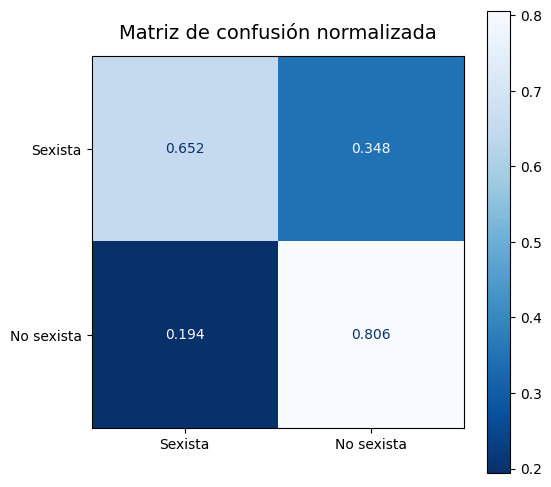

In [15]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues_r",values_format=".3f",ax=ax,colorbar=True)
    ax.set_title("Matriz de confusión normalizada", fontsize=14, pad=12)
    ax.set(xlabel=None, ylabel=None)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()

labels = list(set(dataset_ES["train"]["label"]))
label_map = {0: "Sexista", 1: "No sexista"}
display_labels = [label_map[l] for l in sorted(labels)]

plot_confusion_matrix(
    y_preds=results_test["y_pred"],
    y_true=results_test["y_true"],
    labels=display_labels
)